# Parte 2: Extracción de Descriptores Clásicos

Este notebook implementa la extracción de descriptores de forma y textura para las imágenes de rayos X.


In [2]:
# Importación de librerías
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops
from skimage.filters import gabor
from scipy import ndimage
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Configuración
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Funciones de preprocesamiento (si no están disponibles desde otros módulos)
def apply_clahe(img, clip_limit=2.0, tile_grid_size=(8, 8)):
    """Aplica CLAHE a la imagen"""
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(img)


## 1. Carga de Datos Preprocesados


In [3]:
# Cargar metadatos
try:
    df = pd.read_csv('../data/metadata.csv')
    print(f"✅ Dataset cargado: {len(df)} imágenes")
except:
    print("⚠️  No se encontró metadata.csv. Cargando desde directorio...")
    DATA_DIR = Path('../data/chest_xray')
    TRAIN_DIR = DATA_DIR / 'train'
    TEST_DIR = DATA_DIR / 'test'
    
    def load_image_paths(base_dir, class_name):
        class_dir = base_dir / class_name
        if class_dir.exists():
            return list(class_dir.glob('*.jpeg')) + list(class_dir.glob('*.jpg'))
        return []
    
    train_normal = load_image_paths(TRAIN_DIR, 'NORMAL')
    train_pneumonia = load_image_paths(TRAIN_DIR, 'PNEUMONIA')
    test_normal = load_image_paths(TEST_DIR, 'NORMAL')
    test_pneumonia = load_image_paths(TEST_DIR, 'PNEUMONIA')
    
    data = []
    for paths, split, label in [(train_normal, 'train', 'NORMAL'), 
                                (train_pneumonia, 'train', 'PNEUMONIA'),
                                (test_normal, 'test', 'NORMAL'),
                                (test_pneumonia, 'test', 'PNEUMONIA')]:
        for path in paths:
            data.append({'path': str(path), 'split': split, 'class': label})
    
    df = pd.DataFrame(data)
    print(f"✅ Dataset creado: {len(df)} imágenes")

# Mostrar distribución
print("\n📊 Distribución:")
print(df.groupby(['split', 'class']).size())


✅ Dataset cargado: 5840 imágenes

📊 Distribución:
split  class    
test   NORMAL        234
       PNEUMONIA     390
train  NORMAL       1341
       PNEUMONIA    3875
dtype: int64


## Parte A: Descriptores de Forma

### A.1 Histogram of Oriented Gradients (HOG)


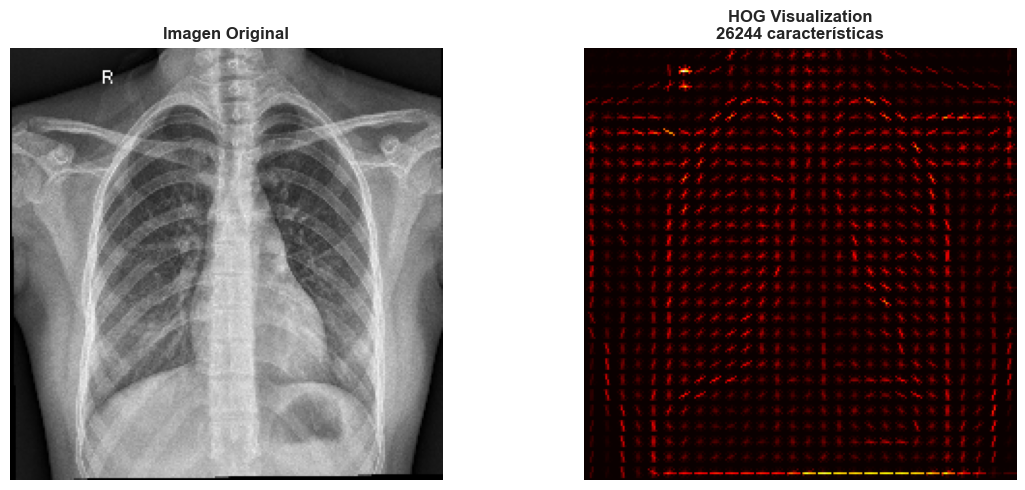

✅ HOG extraído: 26244 características
   Parámetros: orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2)


In [4]:
def extract_hog_features(img, orientations=9, pixels_per_cell=(8, 8), 
                        cells_per_block=(2, 2), visualize=False):
    """
    Extrae características HOG (Histogram of Oriented Gradients).
    
    Args:
        img: Imagen en escala de grises
        orientations: Número de bins de orientación
        pixels_per_cell: Tamaño de celda en píxeles
        cells_per_block: Número de celdas por bloque
        visualize: Si True, retorna también la visualización
    
    Returns:
        Características HOG (y visualización si visualize=True)
    """
    result = hog(
        img,
        orientations=orientations,
        pixels_per_cell=pixels_per_cell,
        cells_per_block=cells_per_block,
        visualize=visualize,
        feature_vector=True
    )
    
    if visualize:
        return result[0], result[1]  # features, hog_image
    else:
        return result  # solo features

# Probar HOG con diferentes parámetros
sample_path = df[df['class'] == 'NORMAL'].iloc[0]['path']
sample_img = cv2.imread(sample_path, cv2.IMREAD_GRAYSCALE)
sample_img = cv2.resize(sample_img, (224, 224))

# Extraer HOG con visualización
hog_features, hog_image = extract_hog_features(sample_img, visualize=True)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(sample_img, cmap='gray')
axes[0].set_title('Imagen Original', fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(hog_image, cmap='hot')
axes[1].set_title(f'HOG Visualization\n{len(hog_features)} características', 
                 fontsize=12, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.savefig('../results/hog_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ HOG extraído: {len(hog_features)} características")
print(f"   Parámetros: orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2)")


### A.2 Momentos de Hu


✅ Momentos de Hu calculados:
   Los 7 momentos invariantes de Hu y sus invarianzas:

   📐 INVARIANZAS GENERALES (todos los momentos):
      • Traslación: No dependen de la posición del objeto en la imagen
      • Rotación: No cambian al rotar el objeto
      • Escala: No dependen del tamaño del objeto (normalizados)

   🔍 PROPIEDADES ESPECÍFICAS DE CADA MOMENTO:
   1. Hu₁: Medida de dispersión espacial (relacionado con varianza)
   2. Hu₂: Medida de asimetría y elongación
   3. Hu₃: Medida de asimetría (skewness)
   4. Hu₄: Medida de kurtosis (curtosis)
   5. Hu₅: Invariante adicional para formas complejas
   6. Hu₆: Invariante adicional para formas complejas
   7. Hu₇: Invariante adicional para formas complejas (más robusto)

   💡 NOTA: Los momentos Hu₁-Hu₄ son los más utilizados y estables.
      Los momentos Hu₅-Hu₇ pueden ser muy pequeños y sensibles al ruido.

   Valores (transformación logarítmica): [  2.93530538   9.17437024   9.99675476   9.96102165 -10.
   9.9999991  -10.     

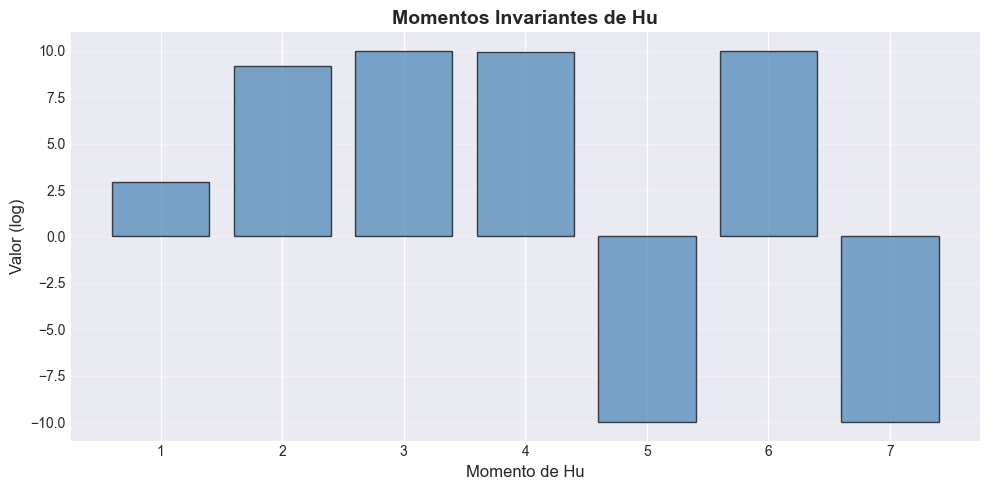

In [5]:
def calculate_hu_moments(img):
    """
    Calcula los 7 momentos invariantes de Hu.
    
    Los momentos de Hu son descriptores de forma que poseen tres invarianzas fundamentales:
    1. **Traslación**: No dependen de la posición del objeto en la imagen
    2. **Rotación**: No cambian cuando el objeto se rota
    3. **Escala**: No dependen del tamaño del objeto (están normalizados)
    
    Propiedades de cada momento:
    - Hu₁: Dispersión espacial (relacionado con varianza)
    - Hu₂: Asimetría y elongación
    - Hu₃: Asimetría (skewness)
    - Hu₄: Kurtosis (curtosis)
    - Hu₅-Hu₇: Invariantes adicionales para formas complejas
    
    Nota: Los momentos Hu₁-Hu₄ son los más estables y utilizados.
          Los momentos Hu₅-Hu₇ pueden ser muy pequeños y sensibles al ruido.
    
    Args:
        img: Imagen binaria o en escala de grises
    
    Returns:
        Array con los 7 momentos de Hu (aplicada transformación logarítmica)
    """
    # Calcular momentos
    moments = cv2.moments(img)
    
    # Calcular momentos de Hu
    hu_moments = cv2.HuMoments(moments).flatten()
    
    # Aplicar transformación logarítmica para hacer los valores más manejables
    # (los momentos de Hu pueden ser muy pequeños)
    hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments) + 1e-10)
    
    return hu_moments

# Probar momentos de Hu
hu_moments = calculate_hu_moments(sample_img)

print("✅ Momentos de Hu calculados:")
print("   Los 7 momentos invariantes de Hu y sus invarianzas:")
print("\n   📐 INVARIANZAS GENERALES (todos los momentos):")
print("      • Traslación: No dependen de la posición del objeto en la imagen")
print("      • Rotación: No cambian al rotar el objeto")
print("      • Escala: No dependen del tamaño del objeto (normalizados)")
print("\n   🔍 PROPIEDADES ESPECÍFICAS DE CADA MOMENTO:")
print("   1. Hu₁: Medida de dispersión espacial (relacionado con varianza)")
print("   2. Hu₂: Medida de asimetría y elongación")
print("   3. Hu₃: Medida de asimetría (skewness)")
print("   4. Hu₄: Medida de kurtosis (curtosis)")
print("   5. Hu₅: Invariante adicional para formas complejas")
print("   6. Hu₆: Invariante adicional para formas complejas")
print("   7. Hu₇: Invariante adicional para formas complejas (más robusto)")
print("\n   💡 NOTA: Los momentos Hu₁-Hu₄ son los más utilizados y estables.")
print("      Los momentos Hu₅-Hu₇ pueden ser muy pequeños y sensibles al ruido.")
print(f"\n   Valores (transformación logarítmica): {hu_moments}")

# Visualizar distribución de momentos
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.bar(range(1, 8), hu_moments, color='steelblue', alpha=0.7, edgecolor='black')
ax.set_xlabel('Momento de Hu', fontsize=12)
ax.set_ylabel('Valor (log)', fontsize=12)
ax.set_title('Momentos Invariantes de Hu', fontsize=14, fontweight='bold')
ax.set_xticks(range(1, 8))
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('../results/hu_moments.png', dpi=150, bbox_inches='tight')
plt.show()


### A.3 Descriptores de Contorno


✅ Descriptores de contorno extraídos:
   area: 38429.5000
   perimeter: 1133.2174
   circularity: 0.3761
   eccentricity: 0.3892
   solidity: 0.9020


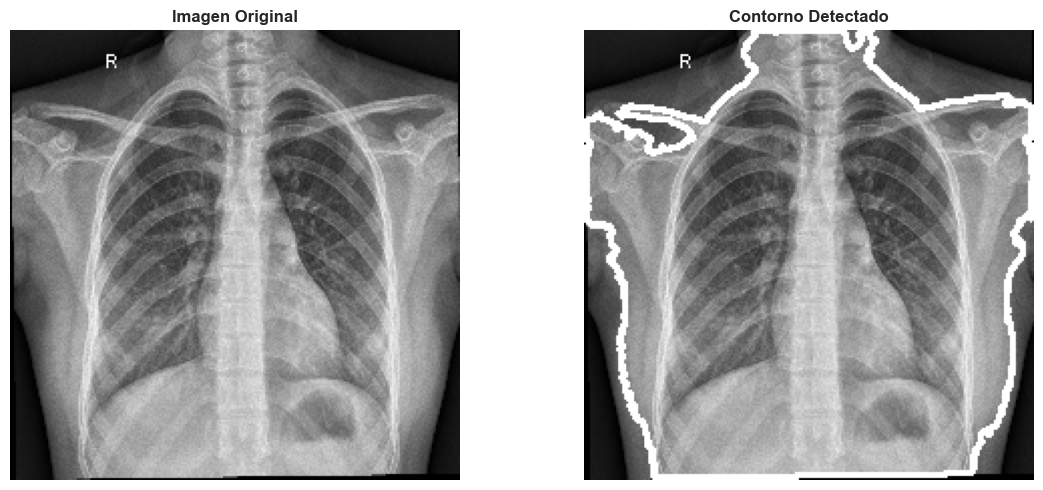

In [17]:
def extract_contour_features(img, threshold_method='otsu'):
    """
    Extrae descriptores de contorno de la imagen.
    Requiere segmentación previa.
    
    Args:
        img: Imagen en escala de grises
        threshold_method: Método de umbralización ('otsu' o 'adaptive')
    
    Returns:
        Diccionario con descriptores de contorno
    """
    # Umbralización
    if threshold_method == 'otsu':
        _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    else:
        binary = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                      cv2.THRESH_BINARY, 11, 2)
    
    # Encontrar contornos
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        return {
            'area': 0,
            'perimeter': 0,
            'circularity': 0,
            'eccentricity': 0,
            'solidity': 0
        }
    
    # Tomar el contorno más grande
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Calcular descriptores
    area = cv2.contourArea(largest_contour)
    perimeter = cv2.arcLength(largest_contour, True)
    
    # Circularidad: 4π*área/perímetro² (1 = círculo perfecto)
    circularity = (4 * np.pi * area) / (perimeter ** 2 + 1e-10)
    
    # Excentricidad (usando elipse ajustada)
    if len(largest_contour) >= 5:
        ellipse = cv2.fitEllipse(largest_contour)
        a, b = ellipse[1][0] / 2, ellipse[1][1] / 2
        if a > b:
            eccentricity = np.sqrt(1 - (b**2 / a**2))
        else:
            eccentricity = np.sqrt(1 - (a**2 / b**2))
    else:
        eccentricity = 0
    
    # Solidez (área del contorno / área del casco convexo)
    hull = cv2.convexHull(largest_contour)
    hull_area = cv2.contourArea(hull)
    solidity = area / (hull_area + 1e-10)
    
    return {
        'area': area,
        'perimeter': perimeter,
        'circularity': circularity,
        'eccentricity': eccentricity,
        'solidity': solidity
    }

# Probar descriptores de contorno
contour_features = extract_contour_features(sample_img)

print("✅ Descriptores de contorno extraídos:")
for key, value in contour_features.items():
    print(f"   {key}: {value:.4f}")

# Visualizar contornos
_, binary = cv2.threshold(sample_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(sample_img, cmap='gray')
axes[0].set_title('Imagen Original', fontsize=12, fontweight='bold')
axes[0].axis('off')

img_with_contours = sample_img.copy()
if len(contours) > 0:
    largest = max(contours, key=cv2.contourArea)
    cv2.drawContours(img_with_contours, [largest], -1, 255, 2)
axes[1].imshow(img_with_contours, cmap='gray')
axes[1].set_title('Contorno Detectado', fontsize=12, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.savefig('../results/contour_features.png', dpi=150, bbox_inches='tight')
plt.show()


### A.4 Fourier Shape Descriptors


✅ Descriptores de Fourier extraídos: 20 coeficientes
   Primeros 5 valores: [0.06870086 0.02111773 0.04601585 0.03702482 0.04689492]


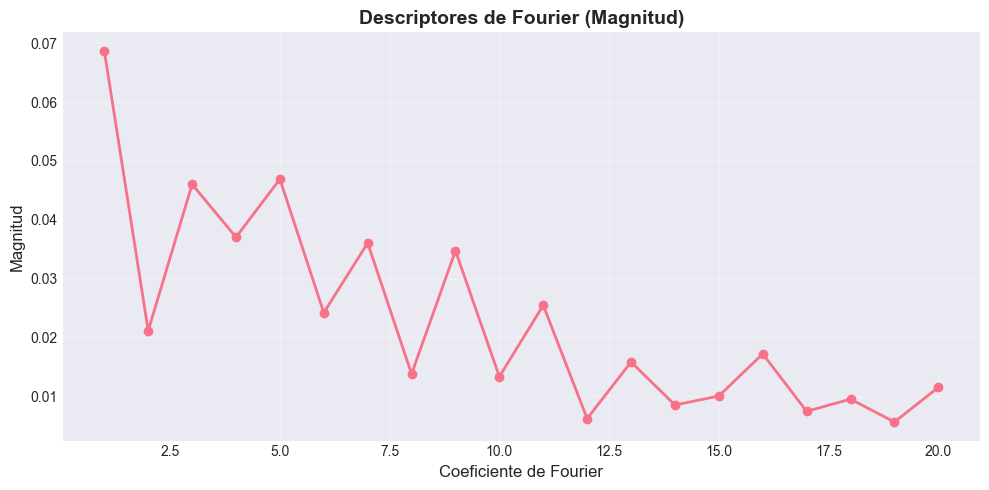

In [18]:
def extract_fourier_descriptors(img, n_coefficients=20):
    """
    Extrae descriptores de Fourier del contorno.
    Representa el contorno en el dominio de la frecuencia.
    
    Args:
        img: Imagen en escala de grises
        n_coefficients: Número de coeficientes a retornar
    
    Returns:
        Array con los primeros N coeficientes de Fourier
    """
    # Umbralizar y encontrar contorno
    _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        return np.zeros(n_coefficients, dtype=complex)
    
    # Tomar el contorno más grande
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Convertir contorno a array complejo (x + iy)
    contour_complex = largest_contour[:, 0, 0] + 1j * largest_contour[:, 0, 1]
    
    # Aplicar FFT
    fft_result = np.fft.fft(contour_complex)
    
    # Normalizar por el primer coeficiente (DC component) para hacerlo invariante a escala
    if fft_result[0] != 0:
        fft_result = fft_result / fft_result[0]
    
    # Tomar los primeros N coeficientes (excluyendo el DC)
    descriptors = fft_result[1:n_coefficients+1]
    
    # Retornar magnitud y fase (o solo magnitud para invarianza a rotación)
    return np.abs(descriptors)  # Solo magnitud para invarianza a rotación

# Probar descriptores de Fourier
fourier_descriptors = extract_fourier_descriptors(sample_img, n_coefficients=20)

print(f"✅ Descriptores de Fourier extraídos: {len(fourier_descriptors)} coeficientes")
print(f"   Primeros 5 valores: {fourier_descriptors[:5]}")

# Visualizar
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(range(1, len(fourier_descriptors) + 1), fourier_descriptors, 
        marker='o', linewidth=2, markersize=6)
ax.set_xlabel('Coeficiente de Fourier', fontsize=12)
ax.set_ylabel('Magnitud', fontsize=12)
ax.set_title('Descriptores de Fourier (Magnitud)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../results/fourier_descriptors.png', dpi=150, bbox_inches='tight')
plt.show()


## Parte B: Descriptores de Textura

### B.1 Local Binary Patterns (LBP)


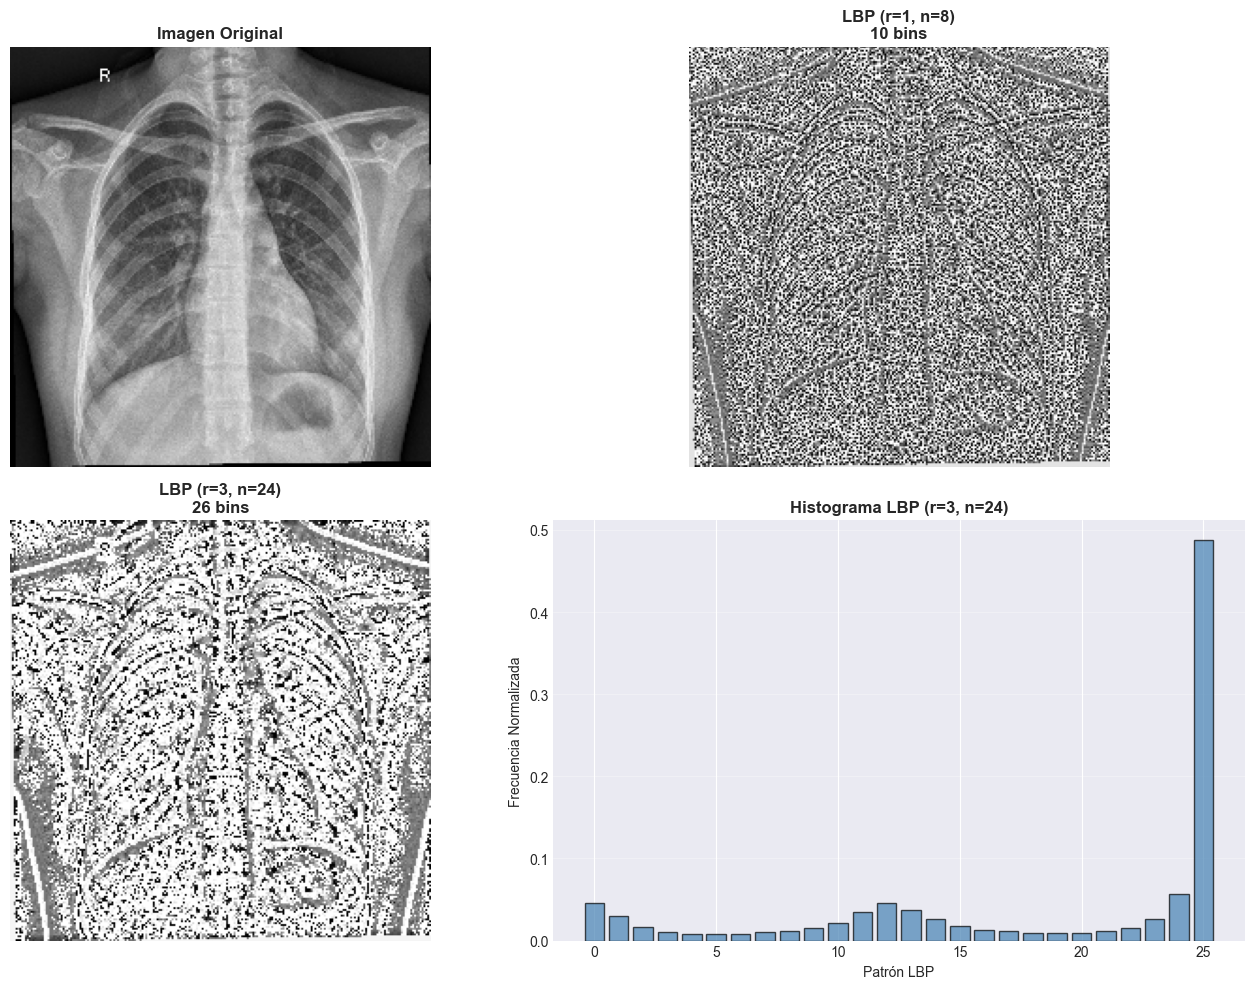

✅ LBP extraído: 26 características (r=3, n=24)


In [19]:
def extract_lbp_features(img, radius=3, n_points=24, method='uniform'):
    """
    Extrae características LBP (Local Binary Patterns).
    
    Args:
        img: Imagen en escala de grises
        radius: Radio del patrón LBP
        n_points: Número de puntos vecinos
        method: Método de LBP ('default', 'ror', 'uniform', 'var')
    
    Returns:
        Histograma de patrones LBP
    """
    # Calcular LBP
    lbp = local_binary_pattern(img, n_points, radius, method=method)
    
    # Calcular histograma
    n_bins = n_points + 2  # Para uniform patterns
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
    
    return hist, lbp

# Probar LBP con diferentes parámetros
lbp_hist_1, lbp_img_1 = extract_lbp_features(sample_img, radius=1, n_points=8)
lbp_hist_2, lbp_img_2 = extract_lbp_features(sample_img, radius=3, n_points=24)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].imshow(sample_img, cmap='gray')
axes[0, 0].set_title('Imagen Original', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(lbp_img_1, cmap='gray')
axes[0, 1].set_title(f'LBP (r=1, n=8)\n{len(lbp_hist_1)} bins', 
                    fontsize=12, fontweight='bold')
axes[0, 1].axis('off')

axes[1, 0].imshow(lbp_img_2, cmap='gray')
axes[1, 0].set_title(f'LBP (r=3, n=24)\n{len(lbp_hist_2)} bins', 
                    fontsize=12, fontweight='bold')
axes[1, 0].axis('off')

axes[1, 1].bar(range(len(lbp_hist_2)), lbp_hist_2, color='steelblue', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Histograma LBP (r=3, n=24)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Patrón LBP')
axes[1, 1].set_ylabel('Frecuencia Normalizada')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../results/lbp_features.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ LBP extraído: {len(lbp_hist_2)} características (r=3, n=24)")


### B.2 Gray Level Co-occurrence Matrix (GLCM)


✅ Características GLCM extraídas:
   contrast: 475.4944
   dissimilarity: 13.3364
   homogeneity: 0.1129
   energy: 0.0133
   correlation: 0.9225
   ASM: 0.0002


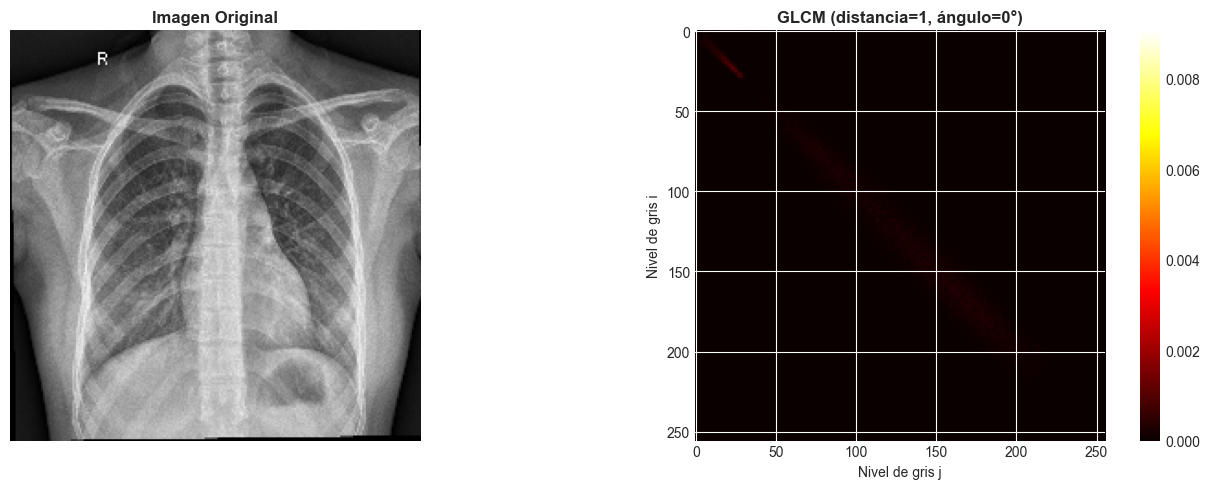

In [20]:
def extract_glcm_features(img, distances=[1, 2, 3], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]):
    """
    Extrae características GLCM (Gray Level Co-occurrence Matrix).
    
    Args:
        img: Imagen en escala de grises
        distances: Lista de distancias para calcular GLCM
        angles: Lista de ángulos en radianes
    
    Returns:
        Diccionario con propiedades GLCM
    """
    # Convertir a enteros de 0-255 si es necesario
    if img.dtype != np.uint8:
        img = (img * 255).astype(np.uint8) if img.max() <= 1.0 else img.astype(np.uint8)
    
    # Calcular GLCM
    glcm = graycomatrix(img, distances=distances, angles=angles, 
                       levels=256, symmetric=True, normed=True)
    
    # Calcular propiedades
    properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
    features = {}
    
    for prop in properties:
        values = graycoprops(glcm, prop)
        # Promediar sobre todas las distancias y ángulos
        features[prop] = np.mean(values)
    
    return features

# Probar GLCM
glcm_features = extract_glcm_features(sample_img)

print("✅ Características GLCM extraídas:")
for key, value in glcm_features.items():
    print(f"   {key}: {value:.4f}")

# Visualizar GLCM
img_uint8 = (sample_img).astype(np.uint8) if sample_img.max() <= 1.0 else sample_img.astype(np.uint8)
glcm = graycomatrix(img_uint8, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].imshow(sample_img, cmap='gray')
axes[0].set_title('Imagen Original', fontsize=12, fontweight='bold')
axes[0].axis('off')

# Visualizar GLCM (solo una distancia y ángulo para visualización)
axes[1].imshow(glcm[:, :, 0, 0], cmap='hot', interpolation='nearest')
axes[1].set_title('GLCM (distancia=1, ángulo=0°)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Nivel de gris j')
axes[1].set_ylabel('Nivel de gris i')
plt.colorbar(axes[1].images[0], ax=axes[1])

plt.tight_layout()
plt.savefig('../results/glcm_features.png', dpi=150, bbox_inches='tight')
plt.show()


### B.3 Filtros de Gabor


✅ Características de Gabor extraídas: 24 características
   (2 estadísticas × 3 frecuencias × 4 orientaciones)


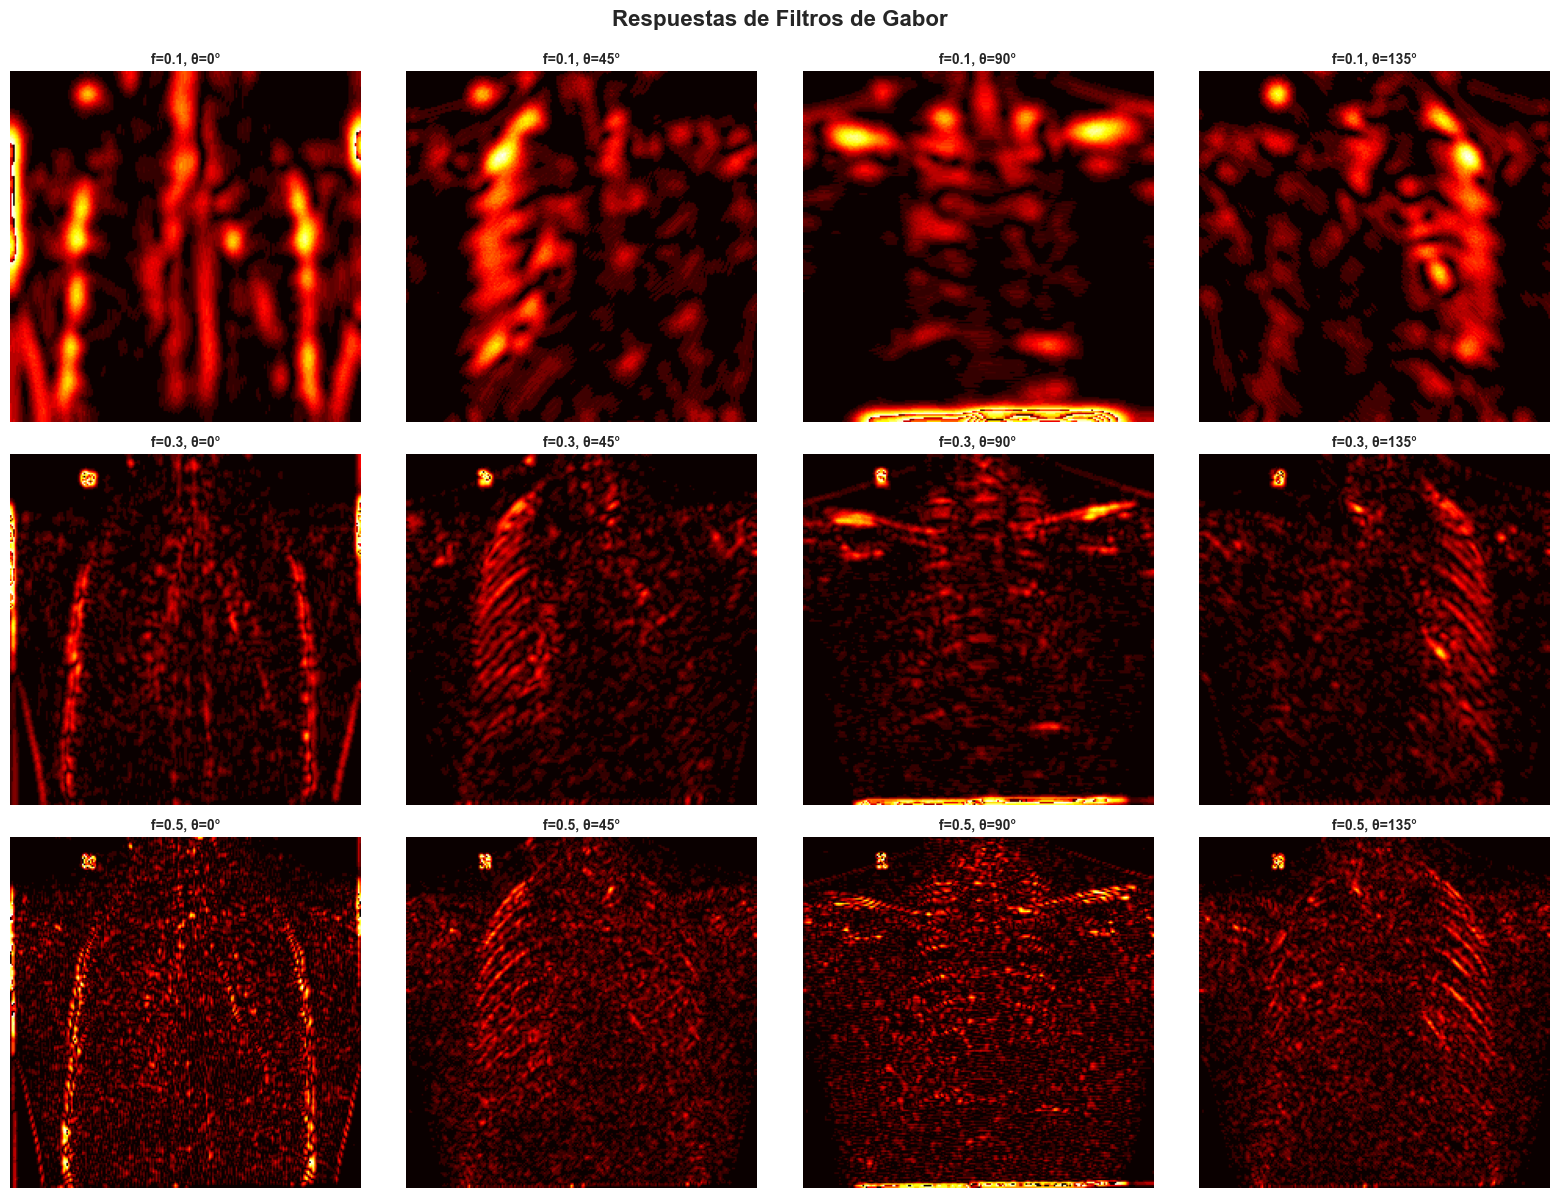

In [21]:
def extract_gabor_features(img, frequencies=[0.1, 0.3, 0.5], 
                          orientations=[0, np.pi/4, np.pi/2, 3*np.pi/4]):
    """
    Extrae características usando filtros de Gabor.
    Crea un banco de filtros con diferentes frecuencias y orientaciones.
    
    Args:
        img: Imagen en escala de grises
        frequencies: Lista de frecuencias
        orientations: Lista de orientaciones en radianes
    
    Returns:
        Array con estadísticas de respuesta (media, std) para cada filtro
    """
    features = []
    
    for frequency in frequencies:
        for theta in orientations:
            # Aplicar filtro de Gabor
            real, imag = gabor(img, frequency=frequency, theta=theta)
            
            # Calcular magnitud de la respuesta
            magnitude = np.sqrt(real**2 + imag**2)
            
            # Estadísticas de respuesta
            features.append(np.mean(magnitude))
            features.append(np.std(magnitude))
    
    return np.array(features)

# Probar filtros de Gabor
gabor_features = extract_gabor_features(sample_img)

print(f"✅ Características de Gabor extraídas: {len(gabor_features)} características")
print(f"   (2 estadísticas × {len([0.1, 0.3, 0.5])} frecuencias × {len([0, np.pi/4, np.pi/2, 3*np.pi/4])} orientaciones)")

# Visualizar respuestas de filtros de Gabor
frequencies = [0.1, 0.3, 0.5]
orientations = [0, np.pi/4, np.pi/2, 3*np.pi/4]

fig, axes = plt.subplots(len(frequencies), len(orientations), figsize=(16, 12))

for i, freq in enumerate(frequencies):
    for j, theta in enumerate(orientations):
        real, imag = gabor(sample_img, frequency=freq, theta=theta)
        magnitude = np.sqrt(real**2 + imag**2)
        
        axes[i, j].imshow(magnitude, cmap='hot')
        axes[i, j].set_title(f'f={freq:.1f}, θ={theta*180/np.pi:.0f}°', 
                           fontsize=10, fontweight='bold')
        axes[i, j].axis('off')

plt.suptitle('Respuestas de Filtros de Gabor', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../results/gabor_features.png', dpi=150, bbox_inches='tight')
plt.show()


### B.4 Estadísticas de Primer Orden


✅ Estadísticas de primer orden extraídas:
   mean: 124.4123
   variance: 3146.9493
   std: 56.0977
   skewness: -0.4536
   kurtosis: -0.6065
   entropy: 7.6385


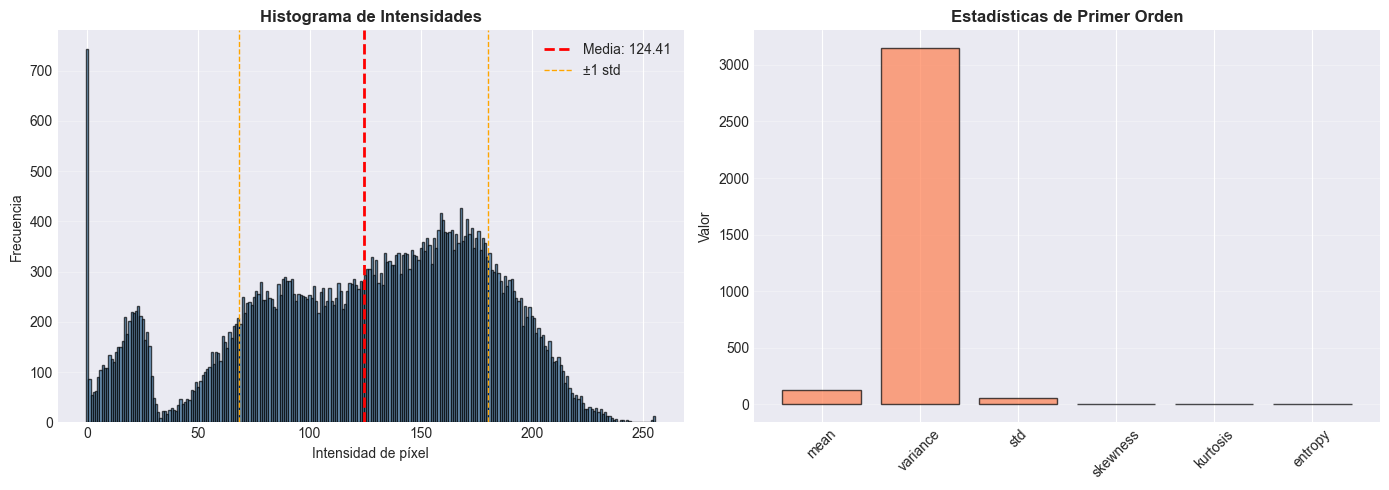

In [22]:
def extract_first_order_statistics(img):
    """
    Extrae estadísticas de primer orden de la imagen.
    
    Args:
        img: Imagen en escala de grises
    
    Returns:
        Diccionario con estadísticas
    """
    # Asegurar que la imagen está en el rango correcto
    if img.max() <= 1.0:
        img = (img * 255).astype(np.uint8)
    else:
        img = img.astype(np.uint8)
    
    # Calcular estadísticas
    mean = np.mean(img)
    variance = np.var(img)
    std = np.std(img)
    
    # Skewness (asimetría)
    skewness = np.mean(((img - mean) / (std + 1e-10)) ** 3)
    
    # Kurtosis (curtosis)
    kurtosis = np.mean(((img - mean) / (std + 1e-10)) ** 4) - 3
    
    # Entropía
    hist, _ = np.histogram(img, bins=256, range=(0, 256))
    hist = hist / (hist.sum() + 1e-10)  # Normalizar
    entropy = -np.sum(hist * np.log2(hist + 1e-10))
    
    return {
        'mean': mean,
        'variance': variance,
        'std': std,
        'skewness': skewness,
        'kurtosis': kurtosis,
        'entropy': entropy
    }

# Probar estadísticas de primer orden
first_order_stats = extract_first_order_statistics(sample_img)

print("✅ Estadísticas de primer orden extraídas:")
for key, value in first_order_stats.items():
    print(f"   {key}: {value:.4f}")

# Visualizar histograma con estadísticas
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

hist, bins = np.histogram(sample_img.flatten(), bins=256, range=(0, 256))
axes[0].bar(bins[:-1], hist, color='steelblue', alpha=0.7, edgecolor='black', width=1)
axes[0].axvline(first_order_stats['mean'], color='red', linestyle='--', 
               label=f"Media: {first_order_stats['mean']:.2f}", linewidth=2)
axes[0].axvline(first_order_stats['mean'] + first_order_stats['std'], 
               color='orange', linestyle='--', label=f"±1 std", linewidth=1)
axes[0].axvline(first_order_stats['mean'] - first_order_stats['std'], 
               color='orange', linestyle='--', linewidth=1)
axes[0].set_title('Histograma de Intensidades', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Intensidad de píxel')
axes[0].set_ylabel('Frecuencia')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Gráfico de barras de estadísticas
stats_names = list(first_order_stats.keys())
stats_values = list(first_order_stats.values())
axes[1].bar(stats_names, stats_values, color='coral', alpha=0.7, edgecolor='black')
axes[1].set_title('Estadísticas de Primer Orden', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Valor')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../results/first_order_stats.png', dpi=150, bbox_inches='tight')
plt.show()


## 3. Función de Extracción Completa

Función que extrae todos los descriptores implementados.


In [23]:
def extract_all_features(img_path, target_size=(224, 224)):
    """
    Extrae todos los descriptores de una imagen.
    
    Args:
        img_path: Ruta a la imagen
        target_size: Tamaño objetivo para preprocesamiento
    
    Returns:
        Diccionario con todos los descriptores
    """
    # Cargar y preprocesar imagen
    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    
    img = cv2.resize(img, target_size)
    img_clahe = apply_clahe(img) if 'apply_clahe' in globals() else cv2.createCLAHE(clipLimit=2.0).apply(img)
    
    features = {}
    
    # Descriptores de forma
    # 1. HOG
    hog_feat = extract_hog_features(img_clahe)
    features['hog'] = hog_feat
    
    # 2. Momentos de Hu
    hu_moments = calculate_hu_moments(img_clahe)
    features['hu_moments'] = hu_moments
    
    # 3. Descriptores de contorno
    contour_feat = extract_contour_features(img_clahe)
    features.update({f'contour_{k}': v for k, v in contour_feat.items()})
    
    # 4. Descriptores de Fourier
    fourier_feat = extract_fourier_descriptors(img_clahe, n_coefficients=20)
    features['fourier'] = fourier_feat
    
    # Descriptores de textura
    # 5. LBP
    lbp_hist, _ = extract_lbp_features(img_clahe, radius=3, n_points=24)
    features['lbp'] = lbp_hist
    
    # 6. GLCM
    glcm_feat = extract_glcm_features(img_clahe)
    features.update({f'glcm_{k}': v for k, v in glcm_feat.items()})
    
    # 7. Gabor
    gabor_feat = extract_gabor_features(img_clahe)
    features['gabor'] = gabor_feat
    
    # 8. Estadísticas de primer orden
    first_order = extract_first_order_statistics(img_clahe)
    features.update({f'first_order_{k}': v for k, v in first_order.items()})
    
    return features

# Probar función completa
sample_path = df.iloc[0]['path']
all_features = extract_all_features(sample_path)

if all_features:
    print("✅ Todos los descriptores extraídos exitosamente")
    print(f"\n📊 Resumen de características:")
    total_features = 0
    for key, value in all_features.items():
        if isinstance(value, np.ndarray):
            print(f"   {key}: {len(value)} características")
            total_features += len(value)
        else:
            print(f"   {key}: 1 característica")
            total_features += 1
    print(f"\n   Total: {total_features} características")


✅ Todos los descriptores extraídos exitosamente

📊 Resumen de características:
   hog: 26244 características
   hu_moments: 7 características
   contour_area: 1 característica
   contour_perimeter: 1 característica
   contour_circularity: 1 característica
   contour_eccentricity: 1 característica
   contour_solidity: 1 característica
   fourier: 20 características
   lbp: 26 características
   glcm_contrast: 1 característica
   glcm_dissimilarity: 1 característica
   glcm_homogeneity: 1 característica
   glcm_energy: 1 característica
   glcm_correlation: 1 característica
   glcm_ASM: 1 característica
   gabor: 24 características
   first_order_mean: 1 característica
   first_order_variance: 1 característica
   first_order_std: 1 característica
   first_order_skewness: 1 característica
   first_order_kurtosis: 1 característica
   first_order_entropy: 1 característica

   Total: 26338 características


## 4. Extracción de Características para Todo el Dataset

⚠️ **Nota**: Esta sección puede tardar bastante tiempo dependiendo del tamaño del dataset. 
Se recomienda ejecutarla en lotes o usar una muestra representativa para pruebas iniciales.


In [24]:
def extract_features_batch(df, sample_size=None, save_path=None):
    """
    Extrae características para un lote de imágenes.
    
    Args:
        df: DataFrame con rutas de imágenes
        sample_size: Si se especifica, solo procesa una muestra
        save_path: Ruta para guardar las características
    
    Returns:
        DataFrame con características y etiquetas
    """
    # Tomar muestra si se especifica
    if sample_size and sample_size < len(df):
        df_sample = df.sample(n=sample_size, random_state=42)
        print(f"📝 Procesando muestra de {sample_size} imágenes...")
    else:
        df_sample = df.copy()
        print(f"📝 Procesando {len(df_sample)} imágenes...")
    
    features_list = []
    labels = []
    paths = []
    
    for idx, row in df_sample.iterrows():
        try:
            feat = extract_all_features(row['path'])
            if feat is not None:
                # Convertir diccionario a array plano
                feature_vector = []
                for key in sorted(feat.keys()):
                    value = feat[key]
                    if isinstance(value, np.ndarray):
                        feature_vector.extend(value.tolist())
                    else:
                        feature_vector.append(value)
                
                features_list.append(feature_vector)
                labels.append(row['class'])
                paths.append(row['path'])
                
                if (len(features_list) % 50 == 0):
                    print(f"   Procesadas: {len(features_list)}/{len(df_sample)}")
        except Exception as e:
            print(f"   Error procesando {row['path']}: {e}")
            continue
    
    # Crear DataFrame
    feature_df = pd.DataFrame(features_list)
    feature_df['label'] = labels
    feature_df['path'] = paths
    
    # Guardar si se especifica
    if save_path:
        feature_df.to_csv(save_path, index=False)
        print(f"\n✅ Características guardadas en: {save_path}")
    
    print(f"\n✅ Extracción completada: {len(feature_df)} imágenes procesadas")
    print(f"   Dimensiones: {feature_df.shape[1] - 2} características + 2 columnas (label, path)")
    
    return feature_df

# Extraer características (usar sample_size para pruebas rápidas)
# Para el dataset completo, comentar sample_size
print("🚀 Iniciando extracción de características...")
print("   (Usando muestra de 100 imágenes para prueba rápida)")
print("   Para procesar todo el dataset, cambiar sample_size=None\n")

features_df = extract_features_batch(df, sample_size=100, save_path='../data/features_sample.csv')

# Mostrar resumen
print("\n📊 Resumen del dataset de características:")
print(features_df.head())
print(f"\nDistribución de clases:")
print(features_df['label'].value_counts())


🚀 Iniciando extracción de características...
   (Usando muestra de 100 imágenes para prueba rápida)
   Para procesar todo el dataset, cambiar sample_size=None

📝 Procesando muestra de 100 imágenes...
   Procesadas: 50/100
   Procesadas: 100/100

✅ Características guardadas en: ../data/features_sample.csv

✅ Extracción completada: 100 imágenes procesadas
   Dimensiones: 26338 características + 2 columnas (label, path)

📊 Resumen del dataset de características:
         0         1         2            3         4         5         6  \
0  41285.5  0.377691  0.491050  1172.021420  0.939845  7.662629 -0.593380   
1  41517.0  0.510467  0.897633  1010.960458  0.911930  7.676750 -0.773806   
2  39948.0  0.292983  0.350972  1308.974738  0.895996  7.641746 -0.988560   
3  35308.0  0.475742  0.714401   965.730010  0.879260  7.289052 -1.297920   
4  39909.0  0.254068  0.689942  1404.964632  0.910520  7.573717 -0.108007   

            7         8          9  ...     26330     26331     26332  \
